In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend as K

In [3]:
os.chdir('/content/drive/My Drive/GitHub Repositories/State of Art Segmentation Network Architectures')
images = np.load('./datasets/Lungs Segmentation from Chest-Xrays Dataset/images_224.npy')
# Z-score Normalization
mean = np.mean(images)
std = np.std(images)
images -= mean
images /= std


masks = np.load('./datasets/Lungs Segmentation from Chest-Xrays Dataset/masks_224.npy')
# Normalize masks to [0, 1]
masks /= 255. 

print('Images: {} | Dtype: {} | Max-Val: {} | Min-Val: {}'.format(images.shape, images.dtype, np.amax(images), np.amin(images)))
print('Masks: {} | Dtype: {} | Max-Val: {} | Min-Val: {}'.format(masks.shape, masks.dtype, np.amax(masks), np.amin(masks)))

images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.05, random_state=2020)
print('Train Images: {} | Train Masks: {}'.format(images_train.shape, masks_train.shape))
print('Validation Images: {} | Validation Masks: {}'.format(images_test.shape, masks_test.shape))

Images: (704, 224, 224, 1) | Dtype: float32 | Max-Val: 1.4882665872573853 | Min-Val: -2.069943904876709
Masks: (704, 224, 224, 1) | Dtype: float32 | Max-Val: 1.0 | Min-Val: 0.0
Train Images: (668, 224, 224, 1) | Train Masks: (668, 224, 224, 1)
Validation Images: (36, 224, 224, 1) | Validation Masks: (36, 224, 224, 1)


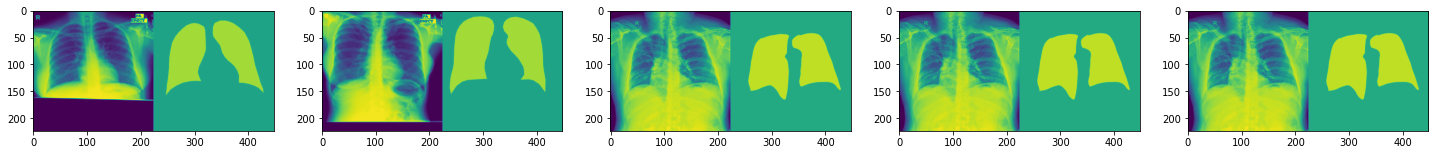

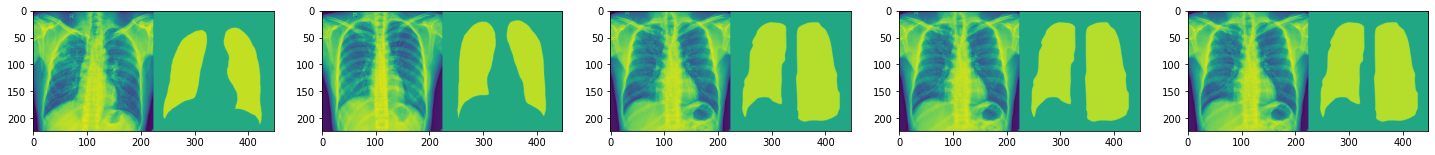

In [4]:
import matplotlib.pyplot as plt

def plotMask(images, masks):
    sample = []
    for i in range(10):
        left = images[i, :, :, 0]
        right = masks[i, :, :, 0]
        combined = np.hstack((left,right))
        sample.append(combined)
        
    for i in range(0, 10, 5):
        plt.figure(figsize=(25,10))
        
        plt.subplot(2, 5, 1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2, 5, 2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2, 5, 3+i)
        plt.imshow(sample[i+2])

        plt.subplot(2, 5, 4+i)
        plt.imshow(sample[i+2])

        plt.subplot(2, 5, 5+i)
        plt.imshow(sample[i+2])
        
        plt.show()

plotMask(images_test, masks_test)

In [5]:
img_rows = 224
img_cols = 224
smooth = 1

def mean_iou(y_true, y_pred):
    true_positives=tf.reduce_sum(tf.round(K.clip(y_true*y_pred, 0, 1)))
    true_negatives=tf.reduce_sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives=tf.reduce_sum(K.round(K.clip((1-y_true), 0, 1)))
    possible_positives=tf.reduce_sum(tf.round(K.clip(y_true, 0, 1)))
    iou = (true_positives)/(possible_negatives - true_negatives + possible_positives + K.epsilon())
    return K.mean(iou)  
  
def sensitivity(y_true,y_pred):
    true_positives=tf.reduce_sum(tf.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives=tf.reduce_sum(tf.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives+K.epsilon())

def specificity(y_true,y_pred):
    true_negatives=tf.reduce_sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives=tf.reduce_sum(K.round(K.clip((1-y_true), 0, 1)))
    return true_negatives / (possible_negatives+K.epsilon())

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1score(y_true, y_pred):
    def recall(y_true, y_pred):
        """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
        how many relevant items are selected. """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
        how many selected items are relevant. """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1score =  2 * ((precision * recall) / (precision + recall))
    return f1score

def FCN8_Architecture():
  inputs = tf.keras.layers.Input((img_rows, img_cols, 1))

  # Block 1
  block1 = tf.keras.layers.Conv2D(32, (3, 3), activation=None, padding='same', name='block1_conv1')(inputs)
  block1 = tf.keras.layers.BatchNormalization()(block1)
  block1 = tf.keras.layers.Activation('relu')(block1)
  block1 = tf.keras.layers.Conv2D(32, (3, 3), activation=None, padding='same', name='block1_conv2')(block1)
  block1 = tf.keras.layers.BatchNormalization()(block1)
  block1 = tf.keras.layers.Activation('relu')(block1)
  block1 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(block1)

  # Block 2
  block2 = tf.keras.layers.Conv2D(64, (3, 3), activation=None, padding='same', name='block2_conv1')(block1)
  block2 = tf.keras.layers.BatchNormalization()(block2)
  block2 = tf.keras.layers.Activation('relu')(block2)
  block2 = tf.keras.layers.Conv2D(64, (3, 3), activation=None, padding='same', name='block2_conv2')(block2)
  block2 = tf.keras.layers.BatchNormalization()(block2)
  block2 = tf.keras.layers.Activation('relu')(block2)
  block2 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(block2)

  # Block 3
  block3 = tf.keras.layers.Conv2D(128, (3, 3), activation=None, padding='same', name='block3_conv1')(block2)
  block3 = tf.keras.layers.BatchNormalization()(block3)
  block3 = tf.keras.layers.Activation('relu')(block3)
  block3 = tf.keras.layers.Conv2D(128, (3, 3), activation=None, padding='same', name='block3_conv2')(block3)
  block3 = tf.keras.layers.BatchNormalization()(block3)
  block3 = tf.keras.layers.Activation('relu')(block3)
  block3 = tf.keras.layers.Conv2D(128, (3, 3), activation=None, padding='same', name='block3_conv3')(block3)
  block3 = tf.keras.layers.BatchNormalization()(block3)
  block3 = tf.keras.layers.Activation('relu')(block3)
  block3 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(block3)

  # Block 4
  block4 = tf.keras.layers.Conv2D(256, (3, 3), activation=None, padding='same', name='block4_conv1')(block3)
  block4 = tf.keras.layers.BatchNormalization()(block4)
  block4 = tf.keras.layers.Activation('relu')(block4)
  block4 = tf.keras.layers.Conv2D(256, (3, 3), activation=None, padding='same', name='block4_conv2')(block4)
  block4 = tf.keras.layers.BatchNormalization()(block4)
  block4 = tf.keras.layers.Activation('relu')(block4)
  block4 = tf.keras.layers.Conv2D(256, (3, 3), activation=None, padding='same', name='block4_conv3')(block4)
  block4 = tf.keras.layers.BatchNormalization()(block4)
  block4 = tf.keras.layers.Activation('relu')(block4)
  block4 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(block4)

  # o = block4
  block5 = tf.keras.layers.Conv2D(256, (5, 5), activation=None, padding='same')(block4)
  block5 = tf.keras.layers.BatchNormalization()(block5)
  block5 = tf.keras.layers.Activation('relu')(block5)
  block5 = tf.keras.layers.Conv2D(256, (3, 3), activation=None, padding='same')(block5)
  block5 = tf.keras.layers.BatchNormalization()(block5)
  block5 = tf.keras.layers.Activation('relu')(block5)
  block5 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4, 4), strides=(2, 2), padding='same')(block5)

  ### pool3 (12, 16, 128) --> (12, 16, 256)
  temp_block3 = tf.keras.layers.Conv2D(256, (3, 3), activation=None, padding='same')(block3)
  temp_block3 = tf.keras.layers.BatchNormalization()(temp_block3)
  temp_block3 = tf.keras.layers.Activation('relu')(temp_block3)
  
  ### concat1 [(16, 16, 256), (16, 16, 256)]
  block5 = tf.keras.layers.concatenate([block5, temp_block3], axis=3)
  block5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(block5)
  block5 = tf.keras.layers.BatchNormalization()(block5)
  block5 = tf.keras.layers.Activation('relu')(block5)

  ### up2 (12, 16, 256) --> (24, 32, 128)
  block6 = tf.keras.layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same')(block5)
  block6 = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(block6)
  block6 = tf.keras.layers.BatchNormalization()(block6)
  block6 = tf.keras.layers.Activation('relu')(block6)

  ### pool2 (24, 32, 64) --> (24, 32, 128)
  temp_block2 = tf.keras.layers.Conv2D(128, (3, 3), activation=None, padding='same')(block2)
  temp_block2 = tf.keras.layers.BatchNormalization()(temp_block2)
  temp_block2 = tf.keras.layers.Activation('relu')(temp_block2)

  ### concat2 [(24, 32, 128), (24, 32, 128)]--> (48, 64, 256)
  block6 = tf.keras.layers.concatenate([block6, temp_block2], axis=3)
  
  ### up3 (24, 32, 128) --> (48, 64, 64)
  block7 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding='same')(block6)
  block7 = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(block7)
  block7 = tf.keras.layers.BatchNormalization()(block7)
  block7 = tf.keras.layers.Activation('relu')(block7)

  ### pool1 (48, 64, 32) --> (48, 64, 64)
  temp_block1 = tf.keras.layers.Conv2D(64, (3, 3), activation=None, padding='same')(block1)
  temp_block1 = tf.keras.layers.BatchNormalization()(temp_block1)
  temp_block1 = tf.keras.layers.Activation('relu')(temp_block1)

  ### concat3 [(48, 64, 64), (48, 64, 64)] --> (48, 64, 128)
  block7 = tf.keras.layers.concatenate([block7, temp_block1], axis=3)
  block7 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(block7)
  block7 = tf.keras.layers.BatchNormalization()(block7)
  block7 = tf.keras.layers.Activation('relu')(block7)

  ### up (48, 64, 32) --> (96, 128, 32)
  block8 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), padding='same')(block7)
  ### mask out (96, 128, 32) --> (96, 128, 1)
  block8 = tf.keras.layers.Conv2D(1, (3, 3), padding='same')(block8)
  outputs = tf.keras.layers.Activation('hard_sigmoid')(block8)
  
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  return model

model = FCN8_Architecture()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=dice_coef_loss, metrics=[tf.keras.metrics.Accuracy(), dice_coef, sensitivity,
                                                                                  specificity, f1score, precision, recall, mean_iou])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Epoch 1/50
105/105 [==============================] - ETA: 0s - loss: -0.8674 - accuracy: 0.7352 - dice_coef: 0.8674 - sensitivity: 0.9293 - specificity: 0.9408 - f1score: 0.8956 - precision: 0.8761 - recall: 0.9293 - mean_iou: 0.8260
Epoch 00001: val_accuracy improved from -inf to 0.24080, saving model to ./saved Models/FCN8 Models/Lungs Segmentation from Chest X-rays/segmentation-best-model.h5
Prediction Results at epoch: 1 are below


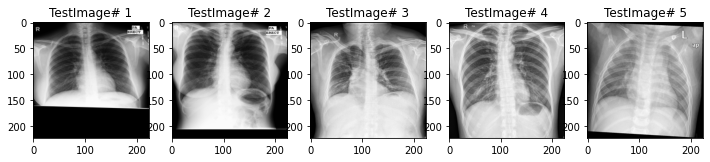

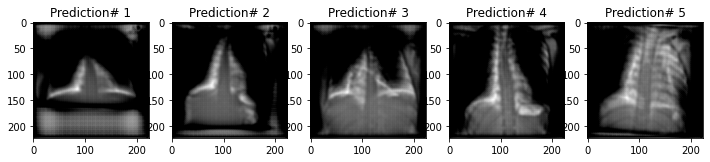

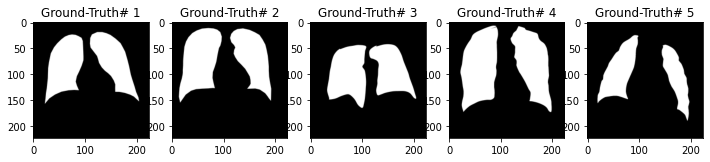

105/105 [==============================] - 96s 913ms/step - loss: -0.8674 - accuracy: 0.7352 - dice_coef: 0.8674 - sensitivity: 0.9293 - specificity: 0.9408 - f1score: 0.8956 - precision: 0.8761 - recall: 0.9293 - mean_iou: 0.8260 - val_loss: -0.1215 - val_accuracy: 0.2408 - val_dice_coef: 0.1215 - val_sensitivity: 0.0000e+00 - val_specificity: 0.9988 - val_f1score: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mean_iou: 0.0000e+00
Epoch 2/50
105/105 [==============================] - ETA: 0s - loss: -0.9550 - accuracy: 0.9045 - dice_coef: 0.9550 - sensitivity: 0.9504 - specificity: 0.9873 - f1score: 0.9561 - precision: 0.9621 - recall: 0.9504 - mean_iou: 0.9158
Epoch 00002: val_accuracy improved from 0.24080 to 0.71314, saving model to ./saved Models/FCN8 Models/Lungs Segmentation from Chest X-rays/segmentation-best-model.h5
105/105 [==============================] - 87s 833ms/step - loss: -0.9550 - accuracy: 0.9045 - dice_coef: 0.9550 - sensitivity: 0.9504 - specific

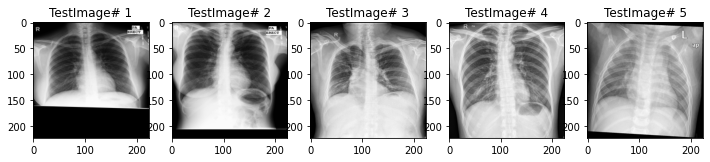

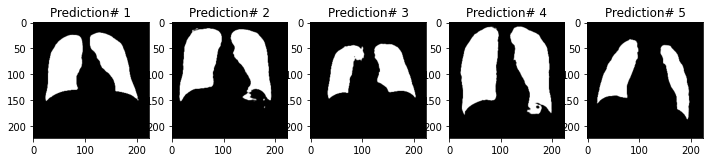

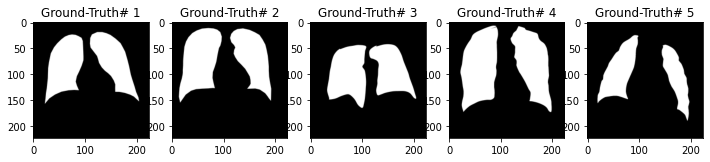

105/105 [==============================] - 88s 839ms/step - loss: -0.9619 - accuracy: 0.9068 - dice_coef: 0.9619 - sensitivity: 0.9586 - specificity: 0.9899 - f1score: 0.9642 - precision: 0.9699 - recall: 0.9586 - mean_iou: 0.9308 - val_loss: -0.9539 - val_accuracy: 0.9395 - val_dice_coef: 0.9539 - val_sensitivity: 0.9315 - val_specificity: 0.9932 - val_f1score: 0.9548 - val_precision: 0.9798 - val_recall: 0.9315 - val_mean_iou: 0.9135
Epoch 12/50
105/105 [==============================] - ETA: 0s - loss: -0.9623 - accuracy: 0.9068 - dice_coef: 0.9623 - sensitivity: 0.9589 - specificity: 0.9901 - f1score: 0.9646 - precision: 0.9705 - recall: 0.9589 - mean_iou: 0.9317
Epoch 00012: val_accuracy improved from 0.94063 to 0.94080, saving model to ./saved Models/FCN8 Models/Lungs Segmentation from Chest X-rays/segmentation-best-model.h5
105/105 [==============================] - 88s 834ms/step - loss: -0.9623 - accuracy: 0.9068 - dice_coef: 0.9623 - sensitivity: 0.9589 - specificity: 0.9901 

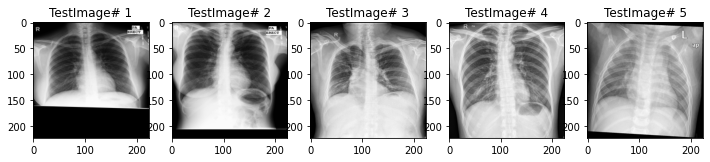

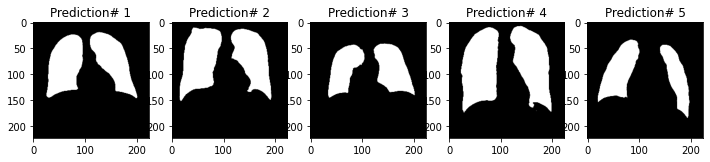

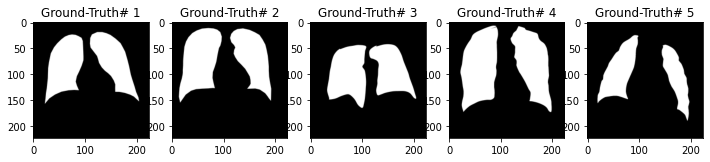

105/105 [==============================] - 88s 841ms/step - loss: -0.9629 - accuracy: 0.9071 - dice_coef: 0.9629 - sensitivity: 0.9603 - specificity: 0.9902 - f1score: 0.9654 - precision: 0.9707 - recall: 0.9603 - mean_iou: 0.9332 - val_loss: -0.9536 - val_accuracy: 0.9408 - val_dice_coef: 0.9536 - val_sensitivity: 0.9286 - val_specificity: 0.9943 - val_f1score: 0.9547 - val_precision: 0.9828 - val_recall: 0.9286 - val_mean_iou: 0.9134
Epoch 22/50
105/105 [==============================] - ETA: 0s - loss: -0.9637 - accuracy: 0.9073 - dice_coef: 0.9637 - sensitivity: 0.9612 - specificity: 0.9905 - f1score: 0.9664 - precision: 0.9718 - recall: 0.9612 - mean_iou: 0.9349
Epoch 00022: val_accuracy improved from 0.94082 to 0.94082, saving model to ./saved Models/FCN8 Models/Lungs Segmentation from Chest X-rays/segmentation-best-model.h5
105/105 [==============================] - 88s 835ms/step - loss: -0.9637 - accuracy: 0.9073 - dice_coef: 0.9637 - sensitivity: 0.9612 - specificity: 0.9905 

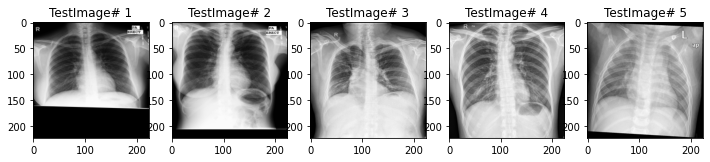

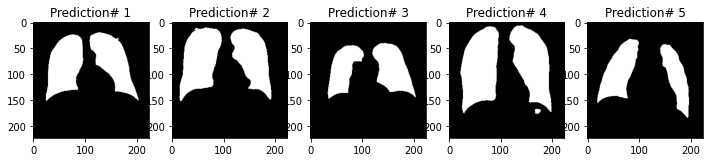

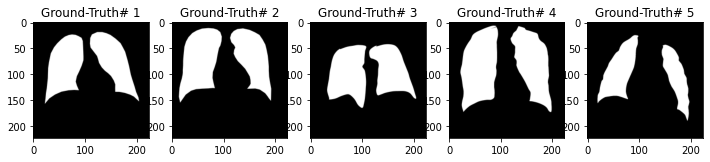

105/105 [==============================] - 88s 841ms/step - loss: -0.9643 - accuracy: 0.9075 - dice_coef: 0.9643 - sensitivity: 0.9627 - specificity: 0.9905 - f1score: 0.9672 - precision: 0.9718 - recall: 0.9627 - mean_iou: 0.9364 - val_loss: -0.9532 - val_accuracy: 0.9398 - val_dice_coef: 0.9532 - val_sensitivity: 0.9347 - val_specificity: 0.9918 - val_f1score: 0.9544 - val_precision: 0.9755 - val_recall: 0.9347 - val_mean_iou: 0.9129
Epoch 32/50
105/105 [==============================] - ETA: 0s - loss: -0.9647 - accuracy: 0.9077 - dice_coef: 0.9647 - sensitivity: 0.9633 - specificity: 0.9906 - f1score: 0.9676 - precision: 0.9719 - recall: 0.9633 - mean_iou: 0.9372
Epoch 00032: val_accuracy did not improve from 0.94097
105/105 [==============================] - 86s 819ms/step - loss: -0.9647 - accuracy: 0.9077 - dice_coef: 0.9647 - sensitivity: 0.9633 - specificity: 0.9906 - f1score: 0.9676 - precision: 0.9719 - recall: 0.9633 - mean_iou: 0.9372 - val_loss: -0.9511 - val_accuracy: 0.

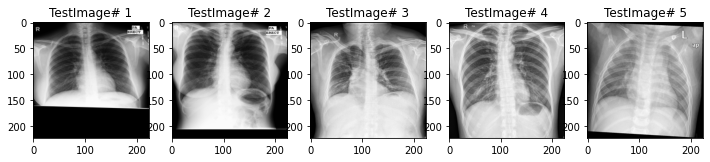

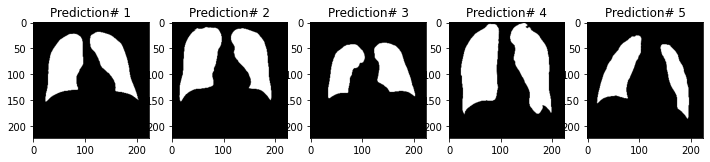

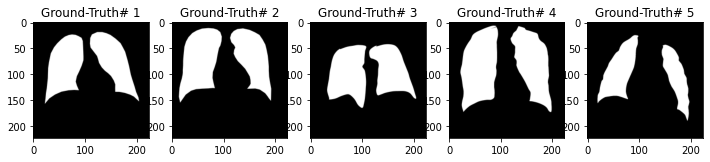

105/105 [==============================] - 88s 841ms/step - loss: -0.9661 - accuracy: 0.9081 - dice_coef: 0.9661 - sensitivity: 0.9652 - specificity: 0.9910 - f1score: 0.9692 - precision: 0.9732 - recall: 0.9652 - mean_iou: 0.9402 - val_loss: -0.9549 - val_accuracy: 0.9409 - val_dice_coef: 0.9549 - val_sensitivity: 0.9340 - val_specificity: 0.9933 - val_f1score: 0.9561 - val_precision: 0.9797 - val_recall: 0.9340 - val_mean_iou: 0.9160
Epoch 42/50
105/105 [==============================] - ETA: 0s - loss: -0.9661 - accuracy: 0.9081 - dice_coef: 0.9661 - sensitivity: 0.9653 - specificity: 0.9910 - f1score: 0.9692 - precision: 0.9731 - recall: 0.9653 - mean_iou: 0.9402
Epoch 00042: val_accuracy did not improve from 0.94143
105/105 [==============================] - 86s 818ms/step - loss: -0.9661 - accuracy: 0.9081 - dice_coef: 0.9661 - sensitivity: 0.9653 - specificity: 0.9910 - f1score: 0.9692 - precision: 0.9731 - recall: 0.9653 - mean_iou: 0.9402 - val_loss: -0.9537 - val_accuracy: 0.

In [10]:
# Data Augumentation
data_gen_args = dict(rotation_range=5,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True,
                     validation_split=0.2)
gen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

seed = 2020
batch_size = 32
def XYaugmentGenerator(X1, y, seed, batch_size):
    genX1 = gen.flow(X1, y, batch_size=batch_size, seed=seed)
    genX2 = gen.flow(y, X1, batch_size=batch_size, seed=seed)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()

        yield X1i[0], X2i[0]




class prediction_history(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (epoch+1) % 10 == 1:
      print('Prediction Results at epoch: {} are below'.format(epoch+1))
      self.pred = model.predict(images_test)
      plot_images(images_test, self.pred, masks_test)
        
def plot_images(images_test, pred, masks_test):
  plt.figure(1, figsize = (12, 12))
  for i in range(5):
    plt.subplot(1, 5, i+1).set_title('TestImage# {}' .format(i+1))
    plt.imshow(images_test[i, :, :, 0], cmap='gray')
  plt.figure(2, figsize = (12, 12))
  for i in range(5):
    plt.subplot(1, 5, i+1).set_title('Prediction# {}' .format(i+1))
    plt.imshow(pred[i, :, :, 0], cmap='gray')
  plt.figure(3, figsize = (12, 12))
  for i in range(5):
    plt.subplot(1, 5, i+1).set_title('Ground-Truth# {}' .format(i+1))
    plt.imshow(masks_test[i, :, :, 0], cmap='gray')
  plt.show()
  plt.close()
  
predictions = prediction_history()

modelDir = './saved Models/FCN8 Models/Lungs Segmentation from Chest X-rays'
if not os.path.exists(modelDir):
  os.makedirs(modelDir)
  print('Directory Created')
  
csv_logger = tf.keras.callbacks.CSVLogger('./saved Models/FCN8 Models/Lungs Segmentation from Chest X-rays/Training-Logs.csv')
checkpoint = tf.keras.callbacks.ModelCheckpoint('./saved Models/FCN8 Models/Lungs Segmentation from Chest X-rays/segmentation-best-model.h5', verbose=1,
                                                monitor='val_accuracy', save_best_only=True, mode='auto')  

# Train model
model.fit(XYaugmentGenerator(images_train, masks_train, seed, batch_size), steps_per_epoch=np.ceil(float(len(images_train)) / float(batch_size))*5,
                validation_data = (images_test, masks_test), shuffle=True, epochs=50, callbacks=[csv_logger, checkpoint, predictions])

model.save('./saved Models/FCN8 Models/Lungs Segmentation from Chest X-rays/segmentation-model.h5')


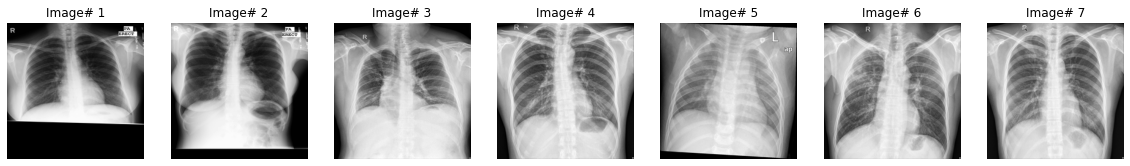

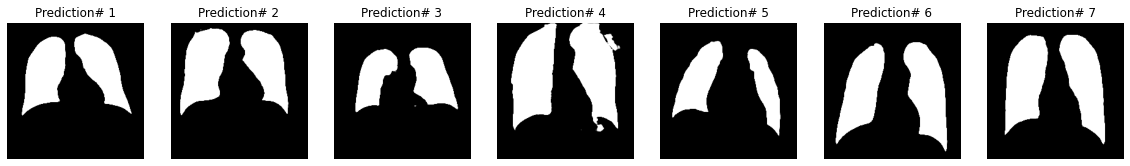

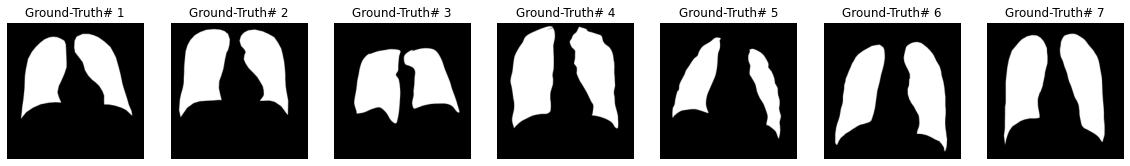

In [11]:
def plot_images(images_test, pred, masks_test):
  plt.figure(1, figsize = (20, 20))
  for i in range(7):
    plt.subplot(1, 7, i+1).set_title('Image# {}' .format(i+1))
    plt.imshow(images_test[i, :, :, 0], cmap='gray')
    plt.axis('off')
  plt.figure(2, figsize = (20, 20))
  for i in range(7):
    plt.subplot(1, 7, i+1).set_title('Prediction# {}' .format(i+1))
    plt.imshow(pred[i, :, :, 0], cmap='gray')
    plt.axis('off')

  plt.figure(3, figsize = (20, 20))
  for i in range(7):
    plt.subplot(1, 7, i+1).set_title('Ground-Truth# {}' .format(i+1))
    plt.imshow(masks_test[i, :, :, 0], cmap='gray')
    plt.axis('off')

  plt.show()
  plt.close()

pred = model.predict(images_test)
plot_images(images_test, pred, masks_test)